In [36]:
from langchain_community.document_loaders.text import TextLoader
from langchain.embeddings.ollama import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List, Tuple
from langchain.docstore.document import Document
import numpy as np
import pandas as pd

In [40]:
def pretty_print_docs(docs):
    if isinstance(docs[0], tuple):
        print(
            f"\n{'-' * 100}\n".join(
                [
                    f"Document {i+1}: ({d[1]})\n\n{d[0].page_content}\nMetadata: {d[0].metadata}"
                    for i, d in enumerate(docs)
                ]
            )
        )
    else:
        print(
            f"\n{'-' * 100}\n".join(
                [
                    f"Document {i+1}:\n\n{d.page_content}\nMetadata: {d.metadata}"
                    for i, d in enumerate(docs)
                ]
            )
        )

def predict(docs_proba: List[Tuple[Document, float]], threshold: float = 0.5) -> Tuple[str, float]:
    # Get the document with the highest probability
    max_proba_doc = max(docs_proba, key=lambda x: x[1])
    print(f"Max probability doc: {max_proba_doc[0].page_content}, {max_proba_doc[1]}")
    if max_proba_doc[1] >= threshold:
        return max_proba_doc[0].page_content, max_proba_doc[1]
    else:
        return "Unknown", 0.5 - max_proba_doc[1]
    

def score_normalizer(val: float) -> float:
    return 1 - (1 / (1 + np.exp(val)))

# Define your custom similarity calculation function
def custom_relevance_score_fn(similarity_score: float) -> float:
    # Example calculation (customize as needed)
    relevance_score = np.exp(-similarity_score)
    return relevance_score

In [21]:
actions_df = pd.read_csv("action_dataset.csv")

actions_possibles = actions_df["action"].unique().tolist()

embedding = OllamaEmbeddings(model="mistral")

In [22]:
from langchain_community.vectorstores.faiss import FAISS, DistanceStrategy

In [23]:
vectordb = None
vectordb = FAISS.from_texts(
    actions_possibles, 
    embedding, 
    normalize_L2=True, 
    distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE, 
    relevance_score_fn=custom_relevance_score_fn
    )
vectordb.save_local("local_vectorstore_faiss")

In [29]:
query = """Je peux vous dire si la journée de demain sera ensoleillée"""
docs_proba = vectordb.similarity_search_with_score(query, k=3)
pretty_print_docs(docs_proba)

Document 1: (0.5997602939605713)

météo, dire le temps qu'il fait
Metadata: {}
----------------------------------------------------------------------------------------------------
Document 2: (0.7079554796218872)

recommander un restaurant
Metadata: {}
----------------------------------------------------------------------------------------------------
Document 3: (0.7220370769500732)

mettre en relation une personne compétente de l'entreprise
Metadata: {}


In [31]:
query = """Je veux savoir si le temps sera ensoleillé demain"""
docs_proba = vectordb.similarity_search_with_relevance_scores(query, k=3)
pretty_print_docs(docs_proba)

Document 1: (0.5218272805213928)

météo, dire le temps qu'il fait
Metadata: {}
----------------------------------------------------------------------------------------------------
Document 2: (0.4689784348011017)

recommander un restaurant
Metadata: {}
----------------------------------------------------------------------------------------------------
Document 3: (0.4513569176197052)

envoyer un mail
Metadata: {}


### Eval with df

In [82]:
# for each assistant_sentence in actions_df["assistant_sentence"]:

result_df = actions_df.copy()
# add a column to store the prediction
result_df["prediction"] = None
result_df["prediction_proba"] = None

for sentence in actions_df["assistant_sentence"]:
    docs_proba = vectordb.similarity_search_with_relevance_scores(sentence, k=3)
    print(f"Assistant sentence: {sentence}")
    prediction, proba = predict(docs_proba, threshold=0.4)
    print(f"   Prediction: {prediction}")

    result_df.loc[result_df["assistant_sentence"] == sentence, "prediction"] = prediction
    result_df.loc[result_df["assistant_sentence"] == sentence, "prediction_proba"] = proba


Assistant sentence: Je connais quelques endroits sympas près de l'entreprise pour déjeuner.
Max probability doc: recommander un restaurant, 0.3181409239768982
   Prediction: Unknown
Assistant sentence: Envie de découvrir de nouveaux restaurants à proximité?
Max probability doc: recommander un restaurant, 0.3209397792816162
   Prediction: Unknown
Assistant sentence: Besoin d'une idée pour déjeuner près d'ici?
Max probability doc: dire au revoir, 0.3969326913356781
   Prediction: Unknown
Assistant sentence: Tu cherches un bon endroit où manger dans le coin?
Max probability doc: dire au revoir, 0.4028012156486511
   Prediction: dire au revoir
Assistant sentence: Je peux te donner quelques suggestions de restaurants à proximité.
Max probability doc: dire au revoir, 0.3241170346736908
   Prediction: Unknown
Assistant sentence: Tu veux des recommandations pour le déjeuner près du bureau?
Max probability doc: dire au revoir, 0.3965100944042206
   Prediction: Unknown
Assistant sentence: Besoin

In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

Accuracy: 0.29285714285714287
Precision: 0.20188989754207146
Recall: 0.29285714285714287
F1: 0.19694891398990924


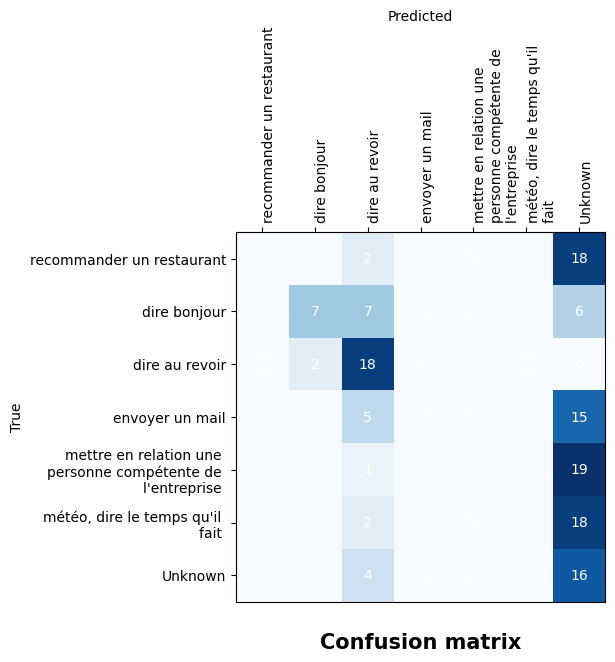

In [84]:
# replace null values with "Unknown"
y = result_df["action"]
y = y.fillna("Unknown")
y_pred = result_df["prediction"]

labels = y.unique()

print(f"Accuracy: {accuracy_score(y, y_pred)}")
print(f"Precision: {precision_score(y, y_pred, average='weighted', zero_division=0)}")
print(f"Recall: {recall_score(y, y_pred, average='weighted')}")
print(f"F1: {f1_score(y, y_pred, average='weighted')}")

c_matrix = np.array(confusion_matrix(y, y_pred, labels=labels))

fig, ax = plt.subplots()
cax = ax.matshow(c_matrix, cmap='Blues')
# text
for (i, j), val in np.ndenumerate(c_matrix):
    ax.text(j, i, f"{val}", ha='center', va='center', color='white')

# insert \n in labels when too long
each_n = 30

def insert_newlines(string, every=each_n):
    words = string.split()
    # if the combined length of the words is less than the every parameter
    if len(' '.join(words)) < every:
        return ' '.join(words)
    
    # if the combined length of the words is greater than the every parameter
    new_string = ''
    current_length = 0
    for word in words:
        if current_length + len(word) > every:
            new_string += '\n'
            current_length = 0
        new_string += word + ' '
        current_length += len(word) + 1
    return new_string

plt_labels = [labels[i] if len(labels[i]) < each_n else insert_newlines(labels[i]) for i in range(len(labels))]

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

plt.xticks(range(len(labels)), plt_labels, rotation=90, ha='left')
plt.yticks(range(len(labels)), plt_labels)

# bottom title
plt.title('Confusion matrix', pad=20, fontsize=15, fontweight='bold', color='black', y=-0.2)
ax.xaxis.set_label_position('top') 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [68]:
def insert_newlines(string, every=each_n):
    words = string.split()
    # if the combined length of the words is less than the every parameter
    if len(' '.join(words)) < every:
        return ' '.join(words)
    
    # if the combined length of the words is greater than the every parameter
    new_string = ''
    current_length = 0
    for word in words:
        if current_length + len(word) > every:
            new_string += '\n'
            current_length = 0
        new_string += word + ' '
        current_length += len(word) + 1
    return new_string


# Example usage:
text = "This is a sample string with some words"
result = insert_newlines(text, 30)  # Insert newline every 5 characters
print(result)

This is a sample string with 
some words 
